In [21]:
%load_ext autoreload
%autoreload 2
from ridge_utils.DataSequence import DataSequence
import pandas as pd
import matplotlib.pyplot as plt
from os.path import dirname
import os
from tqdm import tqdm
from neuro.features import qa_questions, feature_spaces
from neuro.data import story_names, response_utils
from neuro.features.stim_utils import load_story_wordseqs, load_story_wordseqs_huge
import neuro.config
import seaborn as sns
import numpy as np
import joblib
from collections import defaultdict
from os.path import join

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def get_fmri_and_labs(story_name='onapproachtopluto', train_or_test='test', subject='uts03'):
    '''
    Returns
    -------
    df : pd.DataFrame
        The fMRI features, with columns corresponding to the principal components
        of the fMRI data.
    labs : pd.DataFrame
        Binary labeled annotations for each of the texts
    texts: 
        The texts corresponding to the rows of df
    '''
    df = joblib.load(f'{subject}/{train_or_test}/{story_name}.pkl')
    dfs = []
    for offset in [1, 2, 3, 4]:
        df_offset = df.shift(-offset)
        df_offset.columns = [col + f'_{offset}' for col in df.columns]
        dfs.append(df_offset)
    df = pd.concat(dfs, axis=1)  # .dropna()  # would want to dropna here

    # load labels
    labs = joblib.load(f'labels/{train_or_test}/{story_name}_labels.pkl')

    # drop rows with nans
    idxs_na = df.isna().sum(axis=1).values > 0
    df = df[~idxs_na]
    labs = labs[~idxs_na]
    texts = pd.Series(df.index)
    return df, labs, texts

In [ ]:
# load a single story
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegressionCV
df, labs, texts = get_fmri_and_labs()

# load all the data for a single subject
subject = 'uts02'
data = defaultdict(list)
for train_or_test in ['test', 'train']:
    story_names_list = os.listdir(f'{subject}/{train_or_test}')
    for story_name in story_names_list:
        df, labs, texts = get_fmri_and_labs(
            story_name.replace('.pkl', ''), train_or_test, subject)
        data['df_' + train_or_test].append(df)
        data['labs_' + train_or_test].append(labs)
        data['texts_' + train_or_test].append(texts)
for k in data:
    data[k] = pd.concat(data[k], axis=0)

# example fit linear decoder
r = defaultdict(list)
for label_num in tqdm(range(data['labs_train'].shape[1])):
    X_train, y_train = data['df_train'].values, data['labs_train'].values[:, label_num]
    X_test, y_test = data['df_test'].values, data['labs_test'].values[:, label_num]

    # balance the binary class imbalance
    try:
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        X_test, y_test = rus.fit_resample(X_test, y_test)

        if len(y_test) < 30:
            print('too few positive labels', label_num)
            continue

        print('label', label_num,
              data['labs_train'].columns[label_num], X_train.shape, X_test.shape)
        m = LogisticRegressionCV(random_state=42)
        m.fit(X_train, y_train)
        print(
            f"""\ttest acc {m.score(X_test, y_test):.3f}\n\tnaive acc {1 -y_test.mean():.3f}""")
        r['label'].append(data['labs_train'].columns[label_num])
        r['test_acc'].append(m.score(X_test, y_test))
        r['num_test'].append(len(y_test))
    except:
        print('error for', label_num)
        continue

mean acc 0.6674364172732555


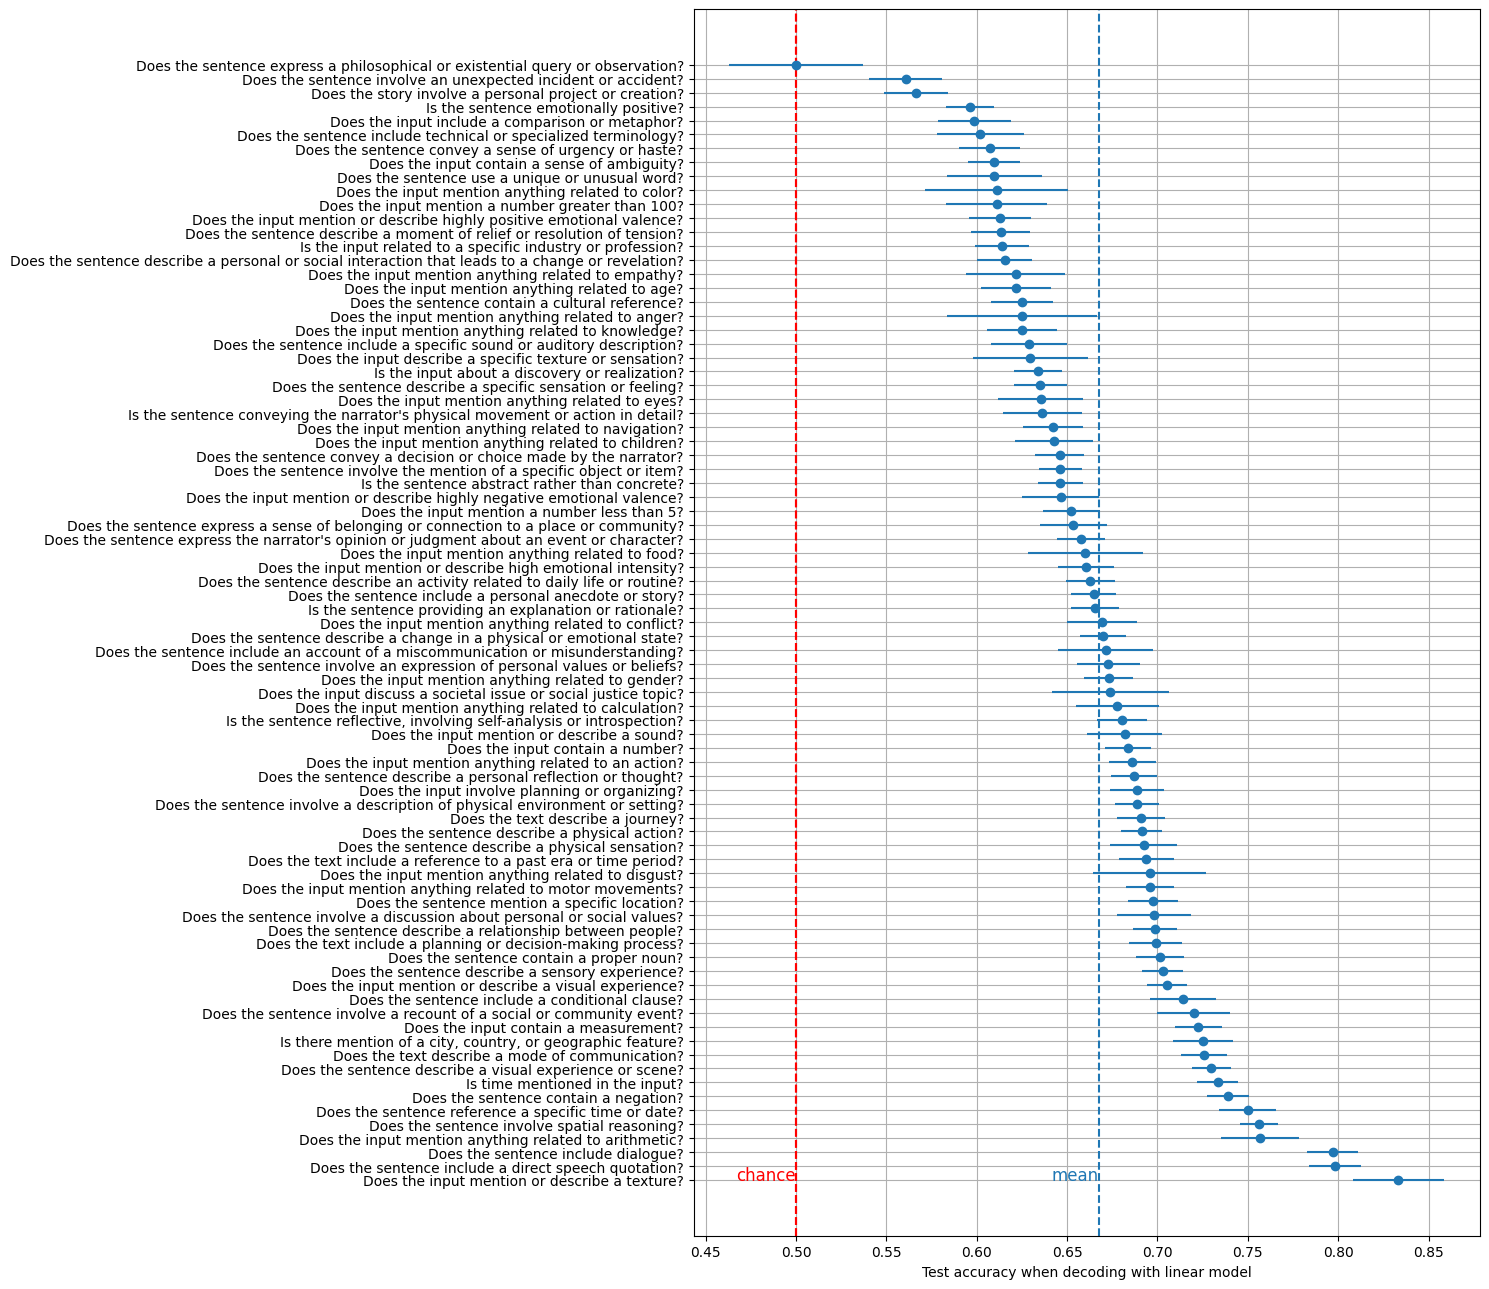

In [31]:
r_df = pd.DataFrame(r).sort_values('test_acc', ascending=False)
plt.figure(figsize=(15, 13))
# sns.barplot(x='test_acc', y='label', data=r_df)
# plot accuracy with binomial error bars
plt.errorbar(
    r_df['test_acc'],
    range(len(r_df)),
    xerr=(r_df['test_acc']*(1-r_df['test_acc'])/np.sqrt(r_df['num_test'])),
    fmt='o')
# add horizontal bars
plt.axvline(0.5, color='red', linestyle='--')
plt.yticks(range(len(r_df)), r_df['label'])
plt.xlabel('Test accuracy when decoding with linear model')
plt.grid()

# annotate with baseline and text label
plt.axvline(0.5, color='red', linestyle='--')
plt.text(0.5, 0, 'chance', color='red', fontsize=12, ha='right')

# annotate with mean and text label
plt.axvline(r_df['test_acc'].mean(), color='C0', linestyle='--')
plt.text(r_df['test_acc'].mean(), 0, 'mean', color='C0',
         fontsize=12, ha='right')
plt.tight_layout()
plt.savefig('linear_decoding.png', dpi=300)

print('mean acc', r_df['test_acc'].mean())